TODO:
1. CNN - done
2. plot - done
3. BLEU
4. early stopping

In [1]:
from __future__ import unicode_literals, print_function, division
import pickle as pkl
from io import open
import unicodedata
import string
import re
import random
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.switch_backend('agg')
import matplotlib.ticker as ticker
%matplotlib inline
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import time
teacher_forcing_ratio = 0.5
import math
device = 'cuda' if torch.cuda.is_available() else 'cpu'


## Data Pre-processing

In [2]:
SOS_token = 0
EOS_token = 1
PAD_IDX = 2
UNK_IDX = 3
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2:"UNK", 3:"PAD"}
        self.n_words = 4  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
def normalizeString(s):
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"&apos;m", r"am", s)
    s = re.sub(r"&apos;s", r"is", s)
    s = re.sub(r"&apos;re", r"are", s)
    s = re.sub(r"&apos;", r"", s)
    return s

In [4]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.5)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()


In [5]:
def loadingLangs(sourcelang, targetlang, setname):
    input_ls = []
    output_ls = []
    print('Reading lines...')
    # Read the file 
    with open('data/iwslt-%s-%s/%s.tok.%s'%(sourcelang, targetlang, setname,sourcelang)) as f:
        for line in f.readlines():
            input_ls.append([normalizeString(word) for word in line.split()])
    with open('data/iwslt-%s-%s/%s.tok.%s'%(sourcelang, targetlang, setname,targetlang)) as f:
        for line in f.readlines():
            output_ls.append([normalizeString(word) for word in line.split()])
    pairs = list(zip(input_ls, output_ls))
    print('Read %s sentence pairs'%(len(input_ls)))
    input_lang = Lang(sourcelang)
    output_lang = Lang(targetlang)
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [6]:
source_tra, target_tra, pairs_tra = loadingLangs('zh', 'en', 'train')

Reading lines...
Read 213377 sentence pairs
Counting words...
Counted words:
zh 88918
en 69063


In [7]:
print("95% of chinese sentences length = {0}".format(np.percentile([len(x[0]) for x in pairs_tra], 95)))
print("95% of english sentences length = {0}".format(np.percentile([len(x[1]) for x in pairs_tra], 95)))
print(random.choice(pairs_tra))

95% of chinese sentences length = 44.0
95% of english sentences length = 48.0
(['钚', '10', '到', '13', '磅', '这', '是', '这么', '多', '这些', '钚', '足以', '制造', '一个', '威力', '相当', '相当于', '当于', '在', '长崎', '爆炸', '的', '那', '枚', '原子', '原子弹', '子弹'], ['Now', ',', 'plutonium', ',', '10', 'to', '13', 'pounds', ':', 'this', ' .', 'This', 'is', 'enough', 'plutonium', 'to', 'create', 'a', 'Nagasaki-size', 'atomic', 'weapon', ' .'])


## Dataset

In [8]:
MAX_SENT_LEN = 50
BATCH_SIZE = 32

In [9]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] if word in lang.word2index else UNK_IDX for word in sentence]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair,source,target):
    input_lang = source
    output_lang = target
    input_tensor = tensorFromSentence(input_lang, pair[0]).reshape((-1))
    target_tensor = tensorFromSentence(output_lang, pair[1]).reshape((-1))
    return (input_tensor, input_tensor.shape[0], target_tensor, target_tensor.shape[0])

In [10]:
class NMTDataset(Dataset):
    def __init__(self, source, target, pairs):
        self.source = source
        self.target = target
        self.pairs = pairs
        
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        inp_ten, inp_len, tar_ten, tar_len = tensorsFromPair(self.pairs[key], self.source, self.target)
        item = {}
        item['inputtensor'] = inp_ten[:MAX_SENT_LEN]
        item['inputlen'] = min(inp_len, MAX_SENT_LEN)
        item['targettensor'] = tar_ten[:MAX_SENT_LEN]
        item['targetlen'] = min(tar_len, MAX_SENT_LEN)
        return item

In [11]:
train_data = NMTDataset(source_tra, target_tra, pairs_tra)
# val_data = NMTDataset(source_val, target_val, pairs_val)
# test_data = NMTDataset(source_tes, target_tes, pairs_tes)

## Dataloader

In [12]:
#collate function

def collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    src_data, tar_data, src_len, tar_len = [], [], [], []
    for datum in batch:        
        src_datum = np.pad(np.array(datum['inputtensor']),
                                pad_width=((0,MAX_SENT_LEN-datum['inputlen'])),
                                mode="constant", constant_values=PAD_IDX)
        tar_datum = np.pad(np.array(datum['targettensor']),
                                pad_width=((0,MAX_SENT_LEN-datum['targetlen'])),
                                mode="constant", constant_values=PAD_IDX)
        src_data.append(src_datum)
        tar_data.append(tar_datum)
        src_len.append(datum['inputlen'])
        tar_len.append(datum['targetlen'])
    return [torch.from_numpy(np.array(src_data)).to(device),torch.from_numpy(np.array(tar_data)).to(device),
               torch.from_numpy(np.array(src_len)).to(device),torch.from_numpy(np.array(tar_len)).to(device)]

In [13]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_func) #### hu change back to True

----------------------

## Model

In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers = 1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, bidirectional=True) 
        self.fc1 = nn.Linear(2*hidden_size, hidden_size)
    def initHidden(self,BATCH_SIZE):
        return torch.zeros(2, BATCH_SIZE, self.hidden_size, device=device) 
    
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, BATCH_SIZE, -1)  
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)  
        output = self.fc1(output)
        return output, hidden

In [15]:
class EncoderCNN(nn.Module):
    def __init__(self, input_size, hidden_size, ker_size=3):
        super(EncoderCNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.conv1 = nn.Conv1d(hidden_size, hidden_size, kernel_size=ker_size, padding=(ker_size-1)//2)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=ker_size, padding=(ker_size-1)//2)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
    
    
    def forward(self, input, hidden):
        seq_len, batch_size = input.size()
        
        embedded = self.embedding(input) 
        output = embedded
        output = self.conv1(output.transpose(1,2)).transpose(1,2)
        output = F.relu(output.contiguous().view(-1, output.size(-1))).view(BATCH_SIZE, seq_len, output.size(-1))

        output = torch.nn.functional.max_pool1d(output.transpose(1,2), seq_len).transpose(1,2)
        output = output.view(-1, output.size(-1))
        output = self.fc1(output)
        return output, output
    
    def initHidden(self,BATCH_SIZE):
        return torch.zeros(1, BATCH_SIZE, self.hidden_size, device=device)

In [16]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_SENT_LEN, n_layers=1):

        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.n_layers = n_layers

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        output= self.embedding(input).view(1, BATCH_SIZE, -1)
        
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)

        return output, hidden

In [17]:
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_SENT_LEN):
        super(AttnDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, BATCH_SIZE, -1)
        embedded = self.dropout(embedded)
        
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)   
        attn_applied = torch.bmm(attn_weights.unsqueeze(1),
                                 encoder_outputs.transpose(0,1))
        
        output = torch.cat((embedded[0], attn_applied.transpose(0,1)[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)

        return output, hidden, attn_weights

-------------------------------

## Train

In [18]:
def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion, mode=None, mode_enc=None):
    encoder_hidden = encoder.initHidden(BATCH_SIZE)
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0) 
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(target_length, BATCH_SIZE, encoder.hidden_size, device=device) 
    loss = 0
    
    # feed-forward layer resulting encoder outputs, ei refers to each word token in input sentence
    for ei in range(input_length):
        if mode_enc == 'cnn':
            if ei >= 10:
                encoder_output, encoder_hidden = encoder(
                    input_tensor[:ei], encoder_hidden)

                encoder_outputs[ei-10] = encoder_output 
        else: 
            encoder_output, encoder_hidden = encoder(
                input_tensor[ei], encoder_hidden)  
            encoder_outputs[ei] = encoder_output[0] 

    if mode_enc == 'cnn':
        encoder_hidden = nn.Linear(hidden_size,hidden_size)(encoder_hidden).unsqueeze(0)
    else:
        encoder_hidden = nn.Linear(2*hidden_size,hidden_size)(
            torch.cat((encoder_hidden[0],encoder_hidden[1]),dim = 1)).unsqueeze(0)
    
    decoder_input = torch.tensor([[SOS_token]*BATCH_SIZE], device=device)  

    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
  
        for di in range(target_length):
            if mode == 'attn':
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                
            
            decoder_input = target_tensor[di]  

            loss += criterion(decoder_output, target_tensor[di]) 

            
    else:
  
        for di in range(target_length):
            if mode == 'attn':
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)

            topv, topi = decoder_output.topk(1)
 
            decoder_input = topi.squeeze().detach() 
  
            loss += criterion(decoder_output, target_tensor[di])


            
    loss.backward()
    
    
    encoder_optimizer.step() 
    decoder_optimizer.step()

    return loss.item() / target_length

-------------------------------------------

RNN+Attn

Time: 0m 15s (- -1m 52s), Epoch: [1/3], Step: [2/6669], Train Loss: 16.643192749023434
Time: 0m 23s (- -1m 42s), Epoch: [1/3], Step: [4/6669], Train Loss: 10.079190368652345
Time: 0m 33s (- -1m 31s), Epoch: [1/3], Step: [6/6669], Train Loss: 9.250121765136718
Time: 0m 41s (- -1m 23s), Epoch: [1/3], Step: [8/6669], Train Loss: 8.669835510253908
Time: 0m 50s (- -1m 14s), Epoch: [1/3], Step: [10/6669], Train Loss: 8.034442443847656
Time: 0m 59s (- -1m 30s), Epoch: [2/3], Step: [2/6669], Train Loss: 11.139737854003906
Time: 1m 6s (- -1m 10s), Epoch: [2/3], Step: [4/6669], Train Loss: 6.590702514648438
Time: 1m 13s (- -2m 59s), Epoch: [2/3], Step: [6/6669], Train Loss: 6.043616943359375
Time: 1m 21s (- -2m 48s), Epoch: [2/3], Step: [8/6669], Train Loss: 5.476578979492187
Time: 1m 31s (- -2m 37s), Epoch: [2/3], Step: [10/6669], Train Loss: 4.867894592285157
Time: 1m 42s (- -1m 8s), Epoch: [3/3], Step: [2/6669], Train Loss: 6.830350494384765
Time: 1m 50s (- -2m 37s), Epoch: [3/3], Step: [4/66

<Figure size 432x288 with 0 Axes>

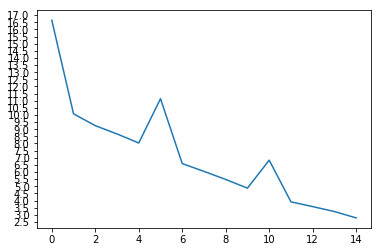

In [19]:
hidden_size = 16 # hu: increase it
learning_rate=0.01
num_epoch = 3
print_every = 2
plot_every = 2
mode = 'attn'
rnn_encoder = EncoderRNN(source_tra.n_words,hidden_size).to(device)
attn_decoder = AttnDecoder(hidden_size, target_tra.n_words, dropout_p=0.1).to(device)

start = time.time()

encoder_optimizer = optim.Adam(rnn_encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(attn_decoder.parameters(), lr=learning_rate)
#hu
criterion = nn.NLLLoss() 

plot_losses = []
print_loss_total = 0 
plot_loss_total = 0  
for epoch in range(1, num_epoch + 1): 
    for i, (input_sentences, target_sentences,len1,len2) in enumerate(train_loader): 
        ##### Hu
       
        #rnn_encoder.train()
        #attn_decoder.train()
        ###Hu
        if i > 10:
            break
            #####
        input_tensor = input_sentences.transpose(0,1)   
        target_tensor = target_sentences.transpose(0,1) 
        loss = train(input_tensor, target_tensor, rnn_encoder,
                     attn_decoder, encoder_optimizer, decoder_optimizer, criterion, mode=mode)
        print_loss_total += loss
        plot_loss_total += loss

        if i > 0 and i % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('Time: {}, Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}'.format(
                    timeSince(start, i + 1/len(train_loader)), epoch, num_epoch, i, 
                    len(train_loader),print_loss_avg))

        if i > 0 and i % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
                
print(plot_losses)
showPlot(plot_losses)

Rnn+noattn

Time: 0m 11s (- -1m 54s), Epoch: [1/3], Step: [2/6669], Train Loss: 16.686149291992187
Time: 0m 21s (- -1m 43s), Epoch: [1/3], Step: [4/6669], Train Loss: 10.65434814453125
Time: 0m 30s (- -1m 34s), Epoch: [1/3], Step: [6/6669], Train Loss: 10.26461151123047
Time: 0m 38s (- -1m 25s), Epoch: [1/3], Step: [8/6669], Train Loss: 9.64865753173828
Time: 0m 47s (- -1m 17s), Epoch: [1/3], Step: [10/6669], Train Loss: 8.882395019531248
Time: 0m 58s (- -1m 30s), Epoch: [2/3], Step: [2/6669], Train Loss: 12.079030761718748
Time: 1m 7s (- -1m 9s), Epoch: [2/3], Step: [4/6669], Train Loss: 7.010560302734375
Time: 1m 15s (- -2m 57s), Epoch: [2/3], Step: [6/6669], Train Loss: 6.380623779296875
Time: 1m 24s (- -2m 46s), Epoch: [2/3], Step: [8/6669], Train Loss: 5.743663940429688
Time: 1m 31s (- -2m 37s), Epoch: [2/3], Step: [10/6669], Train Loss: 5.076470794677734
Time: 1m 42s (- -1m 8s), Epoch: [3/3], Step: [2/6669], Train Loss: 7.0368911743164055
Time: 1m 48s (- -2m 38s), Epoch: [3/3], Step: [4/6669

<Figure size 432x288 with 0 Axes>

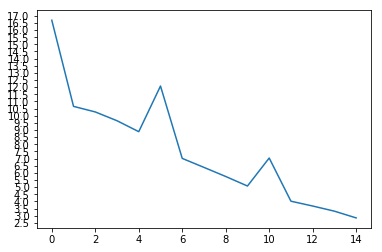

In [20]:
hidden_size = 16 # hu: increase it
learning_rate=0.01
num_epoch = 3
print_every = 2
plot_every = 2
mode = 'noattn'
rnn_encoder = EncoderRNN(source_tra.n_words,hidden_size).to(device)
decoder = Decoder(hidden_size, target_tra.n_words, dropout_p=0.1).to(device)

start = time.time()

encoder_optimizer = optim.Adam(rnn_encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
#hu
criterion = nn.NLLLoss() 

plot_losses = []
#     plot_bleu_score = []
print_loss_total = 0 
plot_loss_total = 0  
for epoch in range(1, num_epoch + 1):
    
    for i, (input_sentences, target_sentences,len1,len2) in enumerate(train_loader): 
        
        ##### Hu
        rnn_encoder.train()
        decoder.train()
        ###Hu: remove it
        if i > 10:
            break

        input_tensor = input_sentences.transpose(0,1)   
        target_tensor = target_sentences.transpose(0,1) 
        loss = train(input_tensor, target_tensor, rnn_encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, mode=mode)
        print_loss_total += loss
        plot_loss_total += loss

        if i > 0 and i % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('Time: {}, Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}'.format(
                    timeSince(start, i + 1/len(train_loader)), epoch, num_epoch, i, 
                    len(train_loader),print_loss_avg))

        if i > 0 and i % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
                
print(plot_losses)
showPlot(plot_losses)

cnn+attn

Time: 0m 11s (- -1m 54s), Epoch: [1/3], Step: [2/6669], Train Loss: 16.561278686523437
Time: 0m 18s (- -1m 45s), Epoch: [1/3], Step: [4/6669], Train Loss: 10.151349487304689
Time: 0m 27s (- -1m 36s), Epoch: [1/3], Step: [6/6669], Train Loss: 9.310890197753906
Time: 0m 34s (- -1m 29s), Epoch: [1/3], Step: [8/6669], Train Loss: 8.657449340820314
Time: 0m 40s (- -1m 23s), Epoch: [1/3], Step: [10/6669], Train Loss: 8.288179321289062
Time: 0m 52s (- -1m 33s), Epoch: [2/3], Step: [2/6669], Train Loss: 11.397132568359375
Time: 0m 58s (- -1m 15s), Epoch: [2/3], Step: [4/6669], Train Loss: 7.084461669921875
Time: 1m 6s (- -1m 4s), Epoch: [2/3], Step: [6/6669], Train Loss: 6.292591552734375
Time: 1m 14s (- -2m 55s), Epoch: [2/3], Step: [8/6669], Train Loss: 5.73257080078125
Time: 1m 22s (- -2m 45s), Epoch: [2/3], Step: [10/6669], Train Loss: 5.182185974121094
Time: 1m 35s (- -1m 12s), Epoch: [3/3], Step: [2/6669], Train Loss: 7.288431396484375
Time: 1m 42s (- -2m 43s), Epoch: [3/3], Step: [4/666

<Figure size 432x288 with 0 Axes>

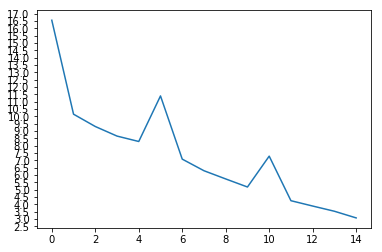

In [21]:
hidden_size = 16 # hu: increase it
learning_rate =0.01
num_epoch = 3
print_every = 2
plot_every = 2
mode = 'attn'
mode_enc = 'cnn'
cnn_encoder = EncoderCNN(source_tra.n_words,hidden_size).to(device)
attn_decoder = AttnDecoder(hidden_size, target_tra.n_words, dropout_p=0.1).to(device)

start = time.time()

encoder_optimizer = optim.Adam(cnn_encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(attn_decoder.parameters(), lr=learning_rate)
#hu
criterion = nn.NLLLoss() 

plot_losses = []
#     plot_bleu_score = []
print_loss_total = 0 
plot_loss_total = 0  
for epoch in range(1, num_epoch + 1):
 
    for i, (input_sentences, target_sentences,len1,len2) in enumerate(train_loader): 
        ##### Hu
       
        cnn_encoder.train()
        attn_decoder.train()
        ###Hu
        if i > 10:
            break
            #####
        input_tensor = input_sentences.transpose(0,1)   
        target_tensor = target_sentences.transpose(0,1) 
        loss = train(input_tensor, target_tensor, cnn_encoder,
                     attn_decoder, encoder_optimizer, decoder_optimizer, criterion, mode=mode, mode_enc=mode_enc)
        print_loss_total += loss
        plot_loss_total += loss

        if i > 0 and i % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('Time: {}, Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}'.format(
                    timeSince(start, i + 1/len(train_loader)), epoch, num_epoch, i, 
                    len(train_loader),print_loss_avg))

        if i > 0 and i % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
                
print(plot_losses)
showPlot(plot_losses)

Time: 0m 11s (- -1m 54s), Epoch: [1/3], Step: [2/6669], Train Loss: 16.484405517578125
Time: 0m 17s (- -1m 46s), Epoch: [1/3], Step: [4/6669], Train Loss: 10.501760253906252
Time: 0m 23s (- -1m 40s), Epoch: [1/3], Step: [6/6669], Train Loss: 10.034223937988282
Time: 0m 31s (- -1m 32s), Epoch: [1/3], Step: [8/6669], Train Loss: 9.538506469726563
Time: 0m 40s (- -1m 23s), Epoch: [1/3], Step: [10/6669], Train Loss: 8.791429138183593
Time: 0m 49s (- -1m 35s), Epoch: [2/3], Step: [2/6669], Train Loss: 12.252068481445312
Time: 0m 56s (- -1m 17s), Epoch: [2/3], Step: [4/6669], Train Loss: 7.266465759277343
Time: 1m 2s (- -1m 7s), Epoch: [2/3], Step: [6/6669], Train Loss: 6.67144775390625
Time: 1m 10s (- -2m 58s), Epoch: [2/3], Step: [8/6669], Train Loss: 6.039183044433594
Time: 1m 16s (- -2m 51s), Epoch: [2/3], Step: [10/6669], Train Loss: 5.431757202148438
Time: 1m 26s (- -1m 16s), Epoch: [3/3], Step: [2/6669], Train Loss: 7.493700408935547
Time: 1m 34s (- -2m 49s), Epoch: [3/3], Step: [4/66

<Figure size 432x288 with 0 Axes>

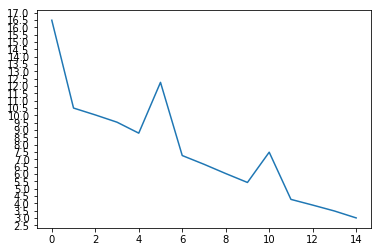

In [22]:
hidden_size = 16 # hu: increase it
learning_rate=0.01
num_epoch = 3
print_every=2
plot_every=2
mode = 'noattn'
mode_enc = 'cnn'
cnn_encoder = EncoderCNN(source_tra.n_words,hidden_size).to(device)
decoder = Decoder(hidden_size, target_tra.n_words, dropout_p=0.1).to(device)

start = time.time()

encoder_optimizer = optim.Adam(cnn_encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
#hu
criterion = nn.NLLLoss() 

plot_losses = []
#     plot_bleu_score = []
print_loss_total = 0 
plot_loss_total = 0  
for epoch in range(1, num_epoch + 1):

    for i, (input_sentences, target_sentences,len1,len2) in enumerate(train_loader): 
        ##### Hu
       
        cnn_encoder.train()
        decoder.train()
        ###Hu
        if i > 10:
            break
            #####
        input_tensor = input_sentences.transpose(0,1)   
        target_tensor = target_sentences.transpose(0,1) 
        loss = train(input_tensor, target_tensor, cnn_encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, mode=mode, mode_enc=mode_enc)
        print_loss_total += loss
        plot_loss_total += loss

        if i > 0 and i % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('Time: {}, Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}'.format(
                    timeSince(start, i + 1/len(train_loader)), epoch, num_epoch, i, 
                    len(train_loader),print_loss_avg))

        if i > 0 and i % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
                
print(plot_losses)
showPlot(plot_losses)